# Topic modelling

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [3]:
df = pd.read_csv("full_df.csv", compression="gzip")

In [4]:
df.head()

,filename,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr,word_level_average_confidence_ocr,word_level_average_confidence_reocr
0,DDD_010197037_001.jp2,"['No.', '9922.', 'Tweede', 'Blad.', 'Vrijdag',...","['JSo.', '9822', 'xTweede', 'Blad.', 'Vrijdag'...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","['ISO.', '9922', '-Tweede', 'Blad.', 'ss*', 'V...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9...",0.719354,0.718463
1,DDD_011219339_001.jp2,"['De', 'Surinamer', 'Redactie', 'J.', 'WILLEBR...","['De', 'Surinamer', '•v*', 'WILLEBRANDS:i^', '...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","['Whd^Mmumr', 'Redactie', 'J.', 'WILLEBRANDS',...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9...",0.765606,0.889051
2,DDD_011179281_001.jp2,"['DE', 'GRONDWET.', 'Mrs.', 'L.', 'Mulder,', '...","['DE', 'GRONDWET.', 'Mrs.', '3L..', 'Mulder,',...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","['DE', 'GRONDWET.', 'Mrs.', 'Xj.', 'Melder,', ...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74...",0.836059,0.805909
3,DDD_010948945_001.jp2,"['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","[0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.86, 0.63,...","['Ê', '•', ':>', '%', 'V', 'f', 'A', 'i', '*',...","[0.27, 0.44, 0.14, 1.0, 0.13, 0.33, 1.0, 0.3, ...",0.881544,0.918112
4,MMGARO01_000177181_002_master.jp2,"['De', 'troepen', 'vertrokken', '8', 'en', '9'...","['De', 'tioepen', 'vertrokken', '8', 'en', '9'...","[0.59, 0.32, 0.32, 0.78, 0.07, 1.0, 0.25, 0.18...","['De', 'troepen', 'vertrokken', '8', 'en', '9'...","[0.5, 0.98, 0.99, 0.41, 0.46, 0.76, 0.61, 0.96...",0.318412,0.877502


In [5]:
#from tabulate import tabulate

In [6]:
#print(tabulate(df.head(2), tablefmt="pipe", headers="keys"))

### Basic exploration

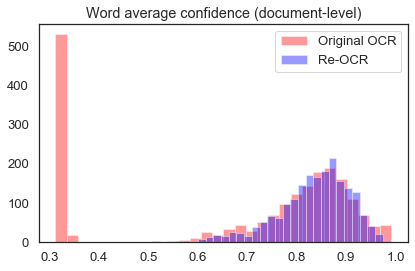

In [7]:
sns.distplot(df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()

### Setup and pre-processing

In [8]:
!python -m spacy download nl


    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/nl_core_news_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/nl

    You can now load the model via spacy.load('nl')



In [17]:
sample_size = 100

sample_ground = df["text_ground"].sample(n=sample_size, random_state=seed)
sample_ocr = df["text_ocr"].sample(n=sample_size, random_state=seed)

In [18]:
print(len(sample_ground))

100


In [19]:
sample_ground[:2]

1480    ['Limburgs', 'Dagblad', 'MEER', 'DAN', 'EEN', ...
1312    ['Tweeduizend', 'banen', 'weg', 'in', 'Rotterd...
Name: text_ground, dtype: object

In [20]:
sample_ocr[:2]

1480    ['Limburgs', 'Dagblad', '_*', 't£*', 'W', 'Maa...
1312    ['Tweeduizend', 'banen', 'weg', 'in', 'Rotterd...
Name: text_ocr, dtype: object

In [24]:
%%time
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(sample_ground, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/ocr_lm/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use

CPU times: user 7min 17s, sys: 1min 40s, total: 8min 58s
Wall time: 3min 52s


In [25]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 25 times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [26]:
# CHANGE this
docs_ground = docs
#docs_ocr = docs

In [27]:
# save corpora
import pickle

with open('topic_modelling/docs_ground.pkl', 'wb') as handle:
    pickle.dump(docs_ground, handle)
with open('topic_modelling/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)

In [9]:
# load corpora
import pickle

docs_ground = list()
docs_ocr = list()

with open('topic_modelling/docs_ground.pkl', 'rb') as handle:
    docs_ground = pickle.load(handle)
with open('topic_modelling/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)

In [10]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ground = Dictionary(docs_ground)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary_ground.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ground = [dictionary_ground.doc2bow(doc) for doc in docs_ground]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ground))
print('Number of docs: %d' % len(corpus_ground))

Number of unique tokens: 4979
Number of docs: 100


In [11]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ocr = Dictionary(docs_ocr)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary_ocr.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ocr = [dictionary_ocr.doc2bow(doc) for doc in docs_ocr]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ocr))
print('Number of docs: %d' % len(corpus_ocr))

Number of unique tokens: 4810
Number of docs: 100


## LDA

In [12]:
%%time

from gensim.models import LdaMulticore
params = {'num_topics': 15,'passes': 1, 'random_state': seed}
model_ground = LdaMulticore(corpus=corpus_ground, num_topics=params['num_topics'], id2word=dictionary_ground, workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 1.77 s, sys: 92.8 ms, total: 1.86 s
Wall time: 720 ms


In [ ]:
%%time

params = {'num_topics': 15,'passes': 1, 'random_state': seed}
model_ocr = LdaMulticore(corpus=corpus_ocr, num_topics=params['num_topics'], id2word=dictionary_ocr, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [14]:
model_ground.show_topics(num_words=5)

[(1,
  '0.002*"eene" + 0.002*"Mei" + 0.002*"leven" + 0.002*"prijs" + 0.002*"Febr"'),
 (7,
  '0.004*"eene" + 0.002*"den_heer" + 0.002*"heden" + 0.002*"Maart" + 0.002*"leven"'),
 (4,
  '0.003*"eene" + 0.002*"commissie" + 0.002*"the" + 0.002*"tussen" + 0.002*"prijs"'),
 (12,
  '0.003*"eene" + 0.002*"den_heer" + 0.002*"tusschen" + 0.002*"Wij" + 0.002*"Rotterdam"'),
 (10,
  '0.004*"den_heer" + 0.002*"April" + 0.002*"eene" + 0.002*"motie" + 0.002*"blad"'),
 (6,
  '0.004*"eene" + 0.002*"toestand" + 0.002*"leven" + 0.002*"Mei" + 0.002*"den_heer"'),
 (13,
  '0.002*"eene" + 0.002*"tussen" + 0.002*"Amerikaanse" + 0.002*"Mei" + 0.002*"Nederlandse"'),
 (14, '0.006*"les" + 0.003*"dans" + 0.003*"eene" + 0.002*"pas" + 0.002*"par"'),
 (11,
  '0.003*"eene" + 0.002*"Maart" + 0.002*"den_heer" + 0.002*"leven" + 0.002*"zijne"'),
 (9,
  '0.003*"eene" + 0.002*"heden" + 0.002*"Mei" + 0.002*"prijzen" + 0.002*"leven"')]

In [ ]:
model_ocr.show_topics(num_words=5)

In [15]:
# plot topics (NOTE: the IDs here do not match those from the model)
data_ground =  pyLDAvis.gensim.prepare(model_ground, corpus_ground, dictionary_ground)
pyLDAvis.display(data_ground)

In [ ]:
# plot topics
data_ocr =  pyLDAvis.gensim.prepare(model_ocr, corpus_ocr, dictionary_ocr)
pyLDAvis.display(data_ocr)

### Evaluation

#### Intrinsic eval

See http://qpleple.com/topic-coherence-to-evaluate-topic-models

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', model_human.log_perplexity(corpus_human))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_human, corpus=corpus_human, dictionary=dictionary_human, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_human, texts=docs_human, dictionary=dictionary_human, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', model_ocr.log_perplexity(corpus_ocr))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_ocr, corpus=corpus_ocr, dictionary=dictionary_ocr, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_ocr, texts=docs_ocr, dictionary=dictionary_ocr, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)